In [17]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# If available, show device information
if torch.cuda.is_available():
    print("CUDA Device Count:", torch.cuda.device_count())
    print("Current CUDA Device:", torch.cuda.current_device())
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("No CUDA-capable devices found.")

CUDA Available: False
No CUDA-capable devices found.


In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
import torch

# Define base directory and paths
BASE_DIR = "D:/p4/dataset"

DATA_FOLDERS = {
    'train': os.path.abspath(os.path.join(BASE_DIR, 'train')),
    'valid': os.path.abspath(os.path.join(BASE_DIR, 'valid')),
    'test': os.path.abspath(os.path.join(BASE_DIR, 'test'))
}

IMAGE_FOLDERS = {
    'train': os.path.join(DATA_FOLDERS['train'], 'images'),
    'valid': os.path.join(DATA_FOLDERS['valid'], 'images'),
    'test': os.path.join(DATA_FOLDERS['test'], 'images')
}

LABEL_FOLDERS = {
    'train': os.path.join(DATA_FOLDERS['train'], 'labels'),
    'valid': os.path.join(DATA_FOLDERS['valid'], 'labels'),
    'test': os.path.join(DATA_FOLDERS['test'], 'labels')
}

# Debug: Print paths to verify
print("Image and Label Paths:")
for split in ['train', 'valid', 'test']:
    print(f"{split} images: {IMAGE_FOLDERS[split]}")
    print(f"{split} labels: {LABEL_FOLDERS[split]}")
    print(f"Images exist: {os.path.exists(IMAGE_FOLDERS[split])}")
    print(f"Labels exist: {os.path.exists(LABEL_FOLDERS[split])}\n")

# Additional Debug: List a few image files and check for labels
for split in ['train', 'valid', 'test']:
    image_folder = IMAGE_FOLDERS[split]
    label_folder = LABEL_FOLDERS[split]
    print(f"\nChecking files in {split}:")
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]
    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        txt_file = f"{base_name}.txt"
        txt_path = os.path.join(label_folder, txt_file)
        print(f"Image: {img_file}, Label exists: {os.path.exists(txt_path)}")

# Constants
IMG_SIZE = (320, 320)
BATCH_SIZE = 64
EPOCHS = 2
WORKERS = 8 

# -----------------------
# 1. Create DataFrame with bounding box annotations
# -----------------------
def process_split(image_folder, label_folder):
    data = []
    valid_count = 0
    missing_txt = 0
    invalid_entries = 0
    skipped_images = 0
    missing_files = []
    
    for img_file in os.listdir(image_folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            base_name = os.path.splitext(img_file)[0]
            txt_file = f"{base_name}.txt"
            txt_path = os.path.join(label_folder, txt_file)
            img_path = os.path.join(image_folder, img_file)
            
            if not os.path.exists(img_path) or os.path.getsize(img_path) == 0:
                skipped_images += 1
                continue
                
            if not os.path.exists(txt_path):
                missing_txt += 1
                missing_files.append(img_file)
                continue
                
            bboxes = []
            with open(txt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        try:
                            class_id = int(parts[0])
                            x_center, y_center, width, height = map(float, parts[1:])
                            bboxes.append([class_id, x_center, y_center, width, height])
                        except (ValueError, IndexError):
                            invalid_entries += 1
                            continue
                    
            if bboxes:
                data.append({
                    'filename': img_path,
                    'bboxes': bboxes
                })
                valid_count += 1

    print(f"\nProcessed {image_folder}:")
    print(f"- Valid images: {valid_count}")
    print(f"- Missing .txt files: {missing_txt}")
    print(f"- Invalid entries: {invalid_entries}")
    print(f"- Skipped images: {skipped_images}")
    
    if missing_files:
        with open(f"missing_labels_{os.path.basename(image_folder)}.txt", 'w') as f:
            for file in missing_files:
                f.write(f"{file}\n")
    
    return pd.DataFrame(data) if data else pd.DataFrame(columns=['filename', 'bboxes'])

print("=== Processing Training Data ===")
train_df = process_split(IMAGE_FOLDERS['train'], LABEL_FOLDERS['train'])
print("\n=== Processing Validation Data ===")
valid_df = process_split(IMAGE_FOLDERS['valid'], LABEL_FOLDERS['valid'])
print("\n=== Processing Test Data ===")
test_df = process_split(IMAGE_FOLDERS['test'], LABEL_FOLDERS['test'])

print("\nTraining data shape:", train_df.shape)
print("Validation data shape:", valid_df.shape)
print("Test data shape:", test_df.shape)

if train_df.empty:
    raise ValueError("Training dataset is empty! No valid images with corresponding labels found in train/labels. Please check the directory structure and ensure label files exist.")

# -----------------------
# 2. Analyze Class Distribution
# -----------------------
def analyze_class_distribution(df):
    all_labels = []
    for bboxes in df['bboxes']:
        all_labels.extend([bbox[0] for bbox in bboxes])
    
    label_counts = pd.Series(all_labels).value_counts().sort_index()
    
    if label_counts.empty:
        print("No labels found in the dataset. Skipping class distribution plot.")
        return label_counts
    
    plt.figure(figsize=(12, 6))
    label_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class Label (Integer)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.close()
    
    return label_counts

print("Analyzing class distribution...")
class_counts = analyze_class_distribution(train_df)
print("Class counts:", class_counts.to_dict())

# -----------------------
# 3. Prepare Class Names
# -----------------------
all_labels = [bbox[0] for bboxes in train_df['bboxes'] for bbox in bboxes]
unique_labels = sorted(set(all_labels))
CLASSES = [str(label) for label in unique_labels]
print(f"Found {len(CLASSES)} unique classes: {CLASSES}")

with open('classes.txt', 'w') as f:
    for cls in CLASSES:
        f.write(f"{cls}\n")

# -----------------------
# 4. Create YOLOv8 Dataset Configuration
# -----------------------
import yaml

data_yaml = {
    'train': IMAGE_FOLDERS['train'],
    'val': IMAGE_FOLDERS['valid'],
    'test': IMAGE_FOLDERS['test'],
    'nc': len(CLASSES),
    'names': CLASSES
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("\nContents of data.yaml:")
with open('data.yaml', 'r') as f:
    print(f.read())

# -----------------------
# 5. Load and Train YOLOv8 Model
# -----------------------
model = YOLO('yolov8n.pt')

results = model.train(
    data='data.yaml',
    imgsz=IMG_SIZE[0],
    batch=BATCH_SIZE,
    epochs=EPOCHS,
    device=0 if torch.cuda.is_available() else 'cpu',  # Use GPU if available
    workers=WORKERS,  # Adjust workers based on device
    patience=10,  # Increased patience for better convergence  # Ensure at least 10 epochs
    project='runs/train',
    name='exp3',
    pretrained=True,
    optimizer='Adam',
    lr0=0.001,
    augment=True
)

# -----------------------
# 6. Evaluate the Model
# -----------------------
print("\nEvaluating model on validation set...")
val_results = model.val(data='data.yaml', split='val')
print("Validation mAP@0.5:", val_results.box.map50)
print("Validation mAP@0.5:0.95:", val_results.box.map)

print("\nEvaluating model on test set...")
test_results = model.val(data='data.yaml', split='test')
print("Test mAP@0.5:", test_results.box.map50)
print("Test mAP@0.5:0.95:", test_results.box.map)

# -----------------------
# 7. Generate Sample Predictions with Highlighted Components
# -----------------------
def generate_sample_predictions(model, df, num_samples=5):
    sample_df = df.sample(n=min(num_samples, len(df)))
    
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = row.filename
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        results = model.predict(img_path, conf=0.5, iou=0.5)
        
        for box in results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            class_id = int(box.cls.cpu().numpy())
            conf = box.conf.cpu().numpy()[0]
            label = f"{CLASSES[class_id]}: {conf:.2f}"
            
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.close()

print("\nGenerating sample predictions...")
generate_sample_predictions(model, test_df)

# -----------------------
# 8. Save Model and Class Mapping
# -----------------------
pd.Series(CLASSES).to_csv('class_labels.csv', index=False, header=False)
with open('label_mapping.json', 'w') as f:
    import json
    json.dump({str(i): cls for i, cls in enumerate(CLASSES)}, f)

print("\nTraining and evaluation complete!")

Image and Label Paths:
train images: D:\p4\dataset\train\images
train labels: D:\p4\dataset\train\labels
Images exist: True
Labels exist: True

valid images: D:\p4\dataset\valid\images
valid labels: D:\p4\dataset\valid\labels
Images exist: True
Labels exist: True

test images: D:\p4\dataset\test\images
test labels: D:\p4\dataset\test\labels
Images exist: True
Labels exist: True


Checking files in train:
Image: 0_0_0.jpg, Label exists: True
Image: 0_0_1280.jpg, Label exists: True
Image: 0_0_1920.jpg, Label exists: True
Image: 0_0_2560.jpg, Label exists: True
Image: 0_0_3200.jpg, Label exists: True

Checking files in valid:
Image: 231_1280_0.jpg, Label exists: True
Image: 231_1280_1280.jpg, Label exists: True
Image: 231_1280_1920.jpg, Label exists: True
Image: 231_1280_2560.jpg, Label exists: True
Image: 231_1280_3200.jpg, Label exists: True

Checking files in test:
Image: 272_0_2560.jpg, Label exists: True
Image: 272_0_3200.jpg, Label exists: True
Image: 272_0_3840.jpg, Label exists: T

train: Scanning D:\p4\dataset\train\labels.cache... 21000 images, 3513 backgrounds, 3271 corrupt: 100%|██████████| 2100

train: WARNING  D:\p4\dataset\train\images\0_1280_3200.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
train: WARNING  D:\p4\dataset\train\images\0_1280_3840.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
train: WARNING  D:\p4\dataset\train\images\0_1920_1280.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
train: WARNING  D:\p4\dataset\train\images\0_1920_1920.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
train: WARNING  D:\p4\dataset\train\images\0_2560_1280.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
train: WARNING  D:\p4\dataset\train\images\0_2560_1920.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels a


val: Scanning D:\p4\dataset\valid\labels.cache... 3000 images, 491 backgrounds, 454 corrupt: 100%|██████████| 3000/3000

val: WARNING  D:\p4\dataset\valid\images\231_1280_3840.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_1280_4480.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_1920_3200.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_1920_3840.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_1920_4480.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_2560_2560.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels a

optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\train\exp34
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.034      2.412     0.8362          2        320: 100%|██████████| 278/278 [39:47<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [02:57


                   all       2546      14841        0.7      0.777      0.815      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      0.741     0.8441     0.8064          7        320: 100%|██████████| 278/278 [36:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [02:21


                   all       2546      14841      0.865      0.904      0.963      0.786

2 epochs completed in 1.356 hours.
Optimizer stripped from runs\train\exp34\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\exp34\weights\best.pt, 6.2MB

Validating runs\train\exp34\weights\best.pt...
Ultralytics 8.3.86  Python-3.9.18 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i7-13700HX)
Model summary (fused): 72 layers, 3,011,888 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [03:55


                   all       2546      14841       0.84      0.899      0.954      0.749
                     2        380        413      0.734      0.881      0.891      0.704
                     3        381        443      0.659      0.989      0.971      0.755
                     4        428        490        0.8      0.961      0.965      0.767
                     5        384        443      0.849      0.941      0.955      0.778
                     6        395        454      0.979      0.812      0.968      0.768
                     7        377        445      0.904      0.751      0.929      0.706
                     8        408        474      0.987      0.473      0.945      0.761
                     9        376        432      0.913      0.949      0.976      0.724
                    10        437        498      0.958      0.984      0.983      0.788
                    11        402        470      0.738      0.994      0.972      0.811
                    1

val: Scanning D:\p4\dataset\valid\labels.cache... 3000 images, 491 backgrounds, 454 corrupt: 100%|██████████| 3000/3000

val: WARNING  D:\p4\dataset\valid\images\231_1280_3840.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_1280_4480.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_1920_3200.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_1920_3840.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_1920_4480.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\valid\images\231_2560_2560.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels a


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [03:47


                   all       2546      14841       0.84      0.899      0.954      0.749
                     2        380        413      0.734      0.881      0.891      0.704
                     3        381        443      0.659      0.989      0.971      0.755
                     4        428        490        0.8      0.961      0.965      0.767
                     5        384        443      0.849      0.941      0.955      0.778
                     6        395        454      0.979      0.812      0.968      0.768
                     7        377        445      0.904      0.751      0.929      0.706
                     8        408        474      0.987      0.473      0.945      0.761
                     9        376        432      0.913      0.949      0.976      0.724
                    10        437        498      0.958      0.984      0.983      0.788
                    11        402        470      0.738      0.994      0.972      0.811
                    1

val: Scanning D:\p4\dataset\test\labels... 6000 images, 933 backgrounds, 1014 corrupt: 100%|██████████| 6000/6000 [00:0

val: WARNING  D:\p4\dataset\test\images\272_1280_1280.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\test\images\272_1280_1920.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\test\images\272_1920_1280.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\test\images\272_1920_1920.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\test\images\273_3200_1280.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31
val: WARNING  D:\p4\dataset\test\images\273_3200_640.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 32. Possible class labels are 0-31

val: New cache created: D:\p4\dataset\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [07:21


                   all       4986      32834      0.817      0.874      0.936      0.723
                     2        859       1006      0.624      0.832      0.824      0.631
                     3        971       1138      0.642      0.978      0.948      0.733
                     4        890       1038      0.696      0.949      0.936      0.733
                     5        813        955      0.792      0.942      0.945      0.748
                     6        820       1044      0.939      0.767      0.935       0.73
                     7        899       1053      0.885      0.688      0.887      0.654
                     8        831        956      0.973      0.373      0.868      0.689
                     9        841        992      0.894      0.853      0.932      0.673
                    10        832        998      0.947      0.964      0.987      0.787
                    11        849        990      0.719      0.982      0.967       0.78
                    1

C:\Users\Aser\AppData\Local\Temp\ipykernel_75308\831365468.py:242: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(box.cls.cpu().numpy())


image 1/1 D:\p4\dataset\test\images\340_1920_3200.jpg: 320x320 1 8, 1 9, 1 10, 1 14, 1 23, 1 25, 451.4ms
Speed: 6.4ms preprocess, 451.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 D:\p4\dataset\test\images\310_2560_0.jpg: 320x320 1 2, 1 3, 1 10, 1 22, 2 25s, 1 28, 1 30, 1 32, 365.0ms
Speed: 1.6ms preprocess, 365.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 D:\p4\dataset\test\images\331_1920_3200.jpg: 320x320 1 2, 1 3, 3 12s, 1 13, 2 14s, 1 15, 1 17, 1 19, 1 20, 1 21, 1 25, 1 30, 531.3ms
Speed: 1.9ms preprocess, 531.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 D:\p4\dataset\test\images\323_640_1280.jpg: 320x320 1 2, 2 3s, 1 9, 2 10s, 5 15s, 1 17, 1 18, 1 21, 1 23, 1 24, 1 30, 2 31s, 1 32, 490.9ms
Speed: 1.8ms preprocess, 490.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)

Training and evaluation complete!


In [31]:
model.save('model_v5.pt')


0: 320x256 1 2, 3 3s, 1 7, 1 9, 1 10, 1 11, 1 15, 1 20, 1 22, 1 25, 1 26, 2 28s, 87.8ms
Speed: 3.3ms preprocess, 87.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)


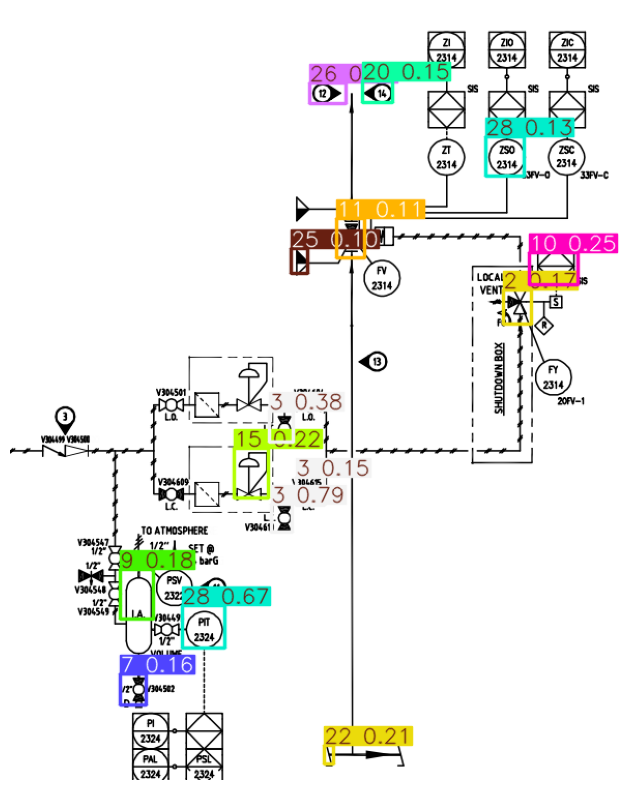

True

In [35]:
model = YOLO("model_v5.pt")  # Replace with your model path

# Load an image
image_path = "sample_test.png"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB

# Run inference
results = model.predict(image, conf=0.1, iou=0.5)  # Adjust confidence and IoU thresholds

# Plot results
annotated_image = results[0].plot()  # Draw bounding boxes and labels

# Display the annotated image
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

# Optionally, save the annotated image
cv2.imwrite("annotated_result.jpg", cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


0: 128x320 1 9, 1 15, 3 21s, 1 23, 1 31, 87.3ms
Speed: 3.1ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 320)


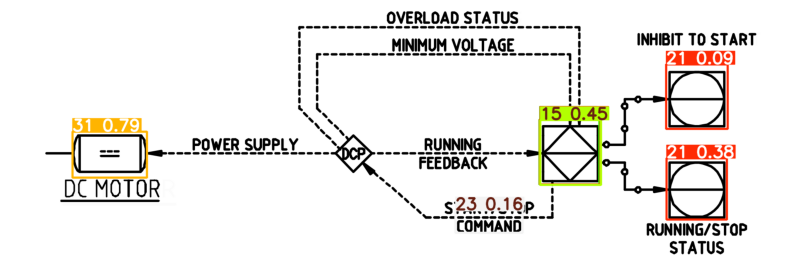

True

In [38]:
model = YOLO("model_v5.pt")  # Replace with your model path

# Load an image
image_path = "sample2_test.png"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB

# Run inference
results = model.predict(image, conf=0.06, iou=0.5)  # Adjust confidence and IoU thresholds

# Plot results
annotated_image = results[0].plot()  # Draw bounding boxes and labels

# Display the annotated image
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

# Optionally, save the annotated image
cv2.imwrite("annotated2_result.jpg", cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


0: 224x320 18 3s, 5 4s, 1 6, 12 7s, 10 9s, 3 10s, 13 11s, 1 13, 3 14s, 21 15s, 1 18, 3 19s, 15 20s, 1 21, 1 22, 3 23s, 3 24s, 5 26s, 1 27, 5 28s, 1 29, 8 30s, 3 32s, 186.6ms
Speed: 1.7ms preprocess, 186.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 320)


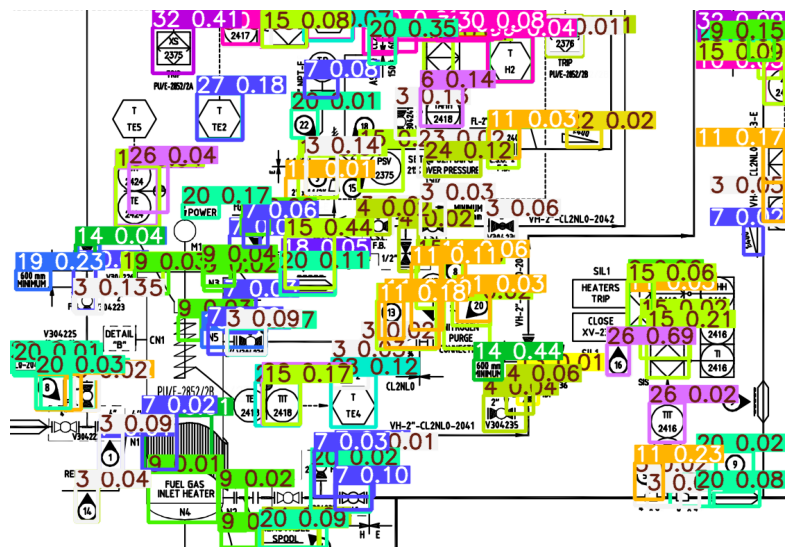

True

In [43]:
model = YOLO("model_v5.pt")  # Replace with your model path

# Load an image
image_path = "sample3_test.png"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB

# Run inference
results = model.predict(image, conf=0.01, iou=0.5)  # Adjust confidence and IoU thresholds

# Plot results
annotated_image = results[0].plot()  # Draw bounding boxes and labels

# Display the annotated image
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

# Optionally, save the annotated image
cv2.imwrite("annotated_result3.jpg", cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))